## Test computational scaling 

Here we give an example of how to measure the training computation time as a function of training iteration and number of dimensions.

In [ ]:
import alabi
from alabi.core import SurrogateModel
from alabi import benchmarks as bm
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.stats import multivariate_normal

Define common settings for all tests

In [2]:
ncore = 1                       # we'll run one active learning chain on one core
ntrain = 100                    # number of initial training samples
savedir = "results/scaling"     # directory to save results

gp_kwargs = {"kernel": "ExpSquaredKernel", 
             "fit_amp": True, 
             "fit_mean": True, 
             "fit_white_noise": False, 
             "white_noise": -12,
             "gp_opt_method": "l-bfgs-b",
             "gp_scale_rng": [-2,2],
             "optimizer_kwargs": {"max_iter": 50, "xatol": 1e-3, "fatol": 1e-2, "adaptive": True}}

al_kwargs = {"algorithm": "bape",
             "gp_opt_freq": 20,
             "obj_opt_method": "nelder-mead",
             "nopt": 1,
             "optimizer_kwargs": {"max_iter": 50, "xatol": 1e-3, "fatol": 1e-2, "adaptive": True}}

Define a general function that trains `alabi` on an N-dimensional Gaussian for `max_iter` iterations

In [3]:
def run_alabi(ndim, max_iter=100, savedir="results/scaling"):

    path = f"{savedir}/multivariate_normal_{ndim}d/"

    # Define the multivariate normal likelihood function
    mean = np.zeros(ndim)
    cov = bm.random_gaussian_covariance(ndim)
    lnlike = partial(multivariate_normal.logpdf, mean=mean, cov=cov)

    # Train surrogate model
    sm = SurrogateModel(lnlike_fn=lnlike,
                        bounds=[(-3., 3.) for _ in range(ndim)],
                        savedir=path,
                        cache=True,
                        verbose=True,
                        ncore=ncore)
    
    # save the true mean and covariance to a file
    np.savez(f"{path}gaussian_mean_cov.npz", mean=mean, cov=cov)

    # Initialize surrogate model 
    if ndim >= 40:
        sm.init_samples(ntrain=ntrain, reload=False, sampler="uniform")
    else:
        sm.init_samples(ntrain=ntrain, reload=False, sampler="sobol")

    sm.init_gp(**gp_kwargs)
    sm.active_train(niter=max_iter, **al_kwargs)
    sm.plot(plots=["gp_all"])

For a quick test, we'll just run `alabi` for a 5-dimensional gaussian and measure the amount of computational overhead `alabi` takes to train the surrogate model. To test more dimensions add them to the `dimensions` array, or to test for more iterations increase `max_iter`. 

In [ ]:
dimensions = [5]
# dimensions = [10, 20, 30]

# Test the scaling of ALABI with dimensionality 
for ndim in dimensions:
    run_alabi(ndim, max_iter=200, savedir=savedir)

Get the recorded train time for each step of `alabi`'s training process.

In [13]:
train_time = []
opt_time = []
test_mse = []
hp_opt_time = []
hp_opt_iter = []

for ndim in dimensions[::-1]: # Reverse order for plotting
    path = f"{savedir}/multivariate_normal_{ndim}d/"
    sm = alabi.load_model_cache(path)
    train_time.append(sm.training_results['gp_train_time'])
    opt_time.append(sm.training_results['obj_fn_opt_time'])
    test_mse.append(sm.training_results['test_mse'])
    hp_opt_time.append(sm.training_results['gp_hyperparam_opt_time'])
    hp_opt_iter.append(sm.training_results['gp_hyperparameter_opt_iteration'])
iterations = sm.training_results['iteration']

train_time = np.array(train_time)
opt_time = np.array(opt_time)
test_mse = np.array(test_mse)
hp_opt_time = np.array(hp_opt_time)
hp_opt_iter = np.array(hp_opt_iter)

cum_time = np.sum(train_time, axis=1) + np.sum(opt_time, axis=1) + np.sum(hp_opt_time, axis=1)

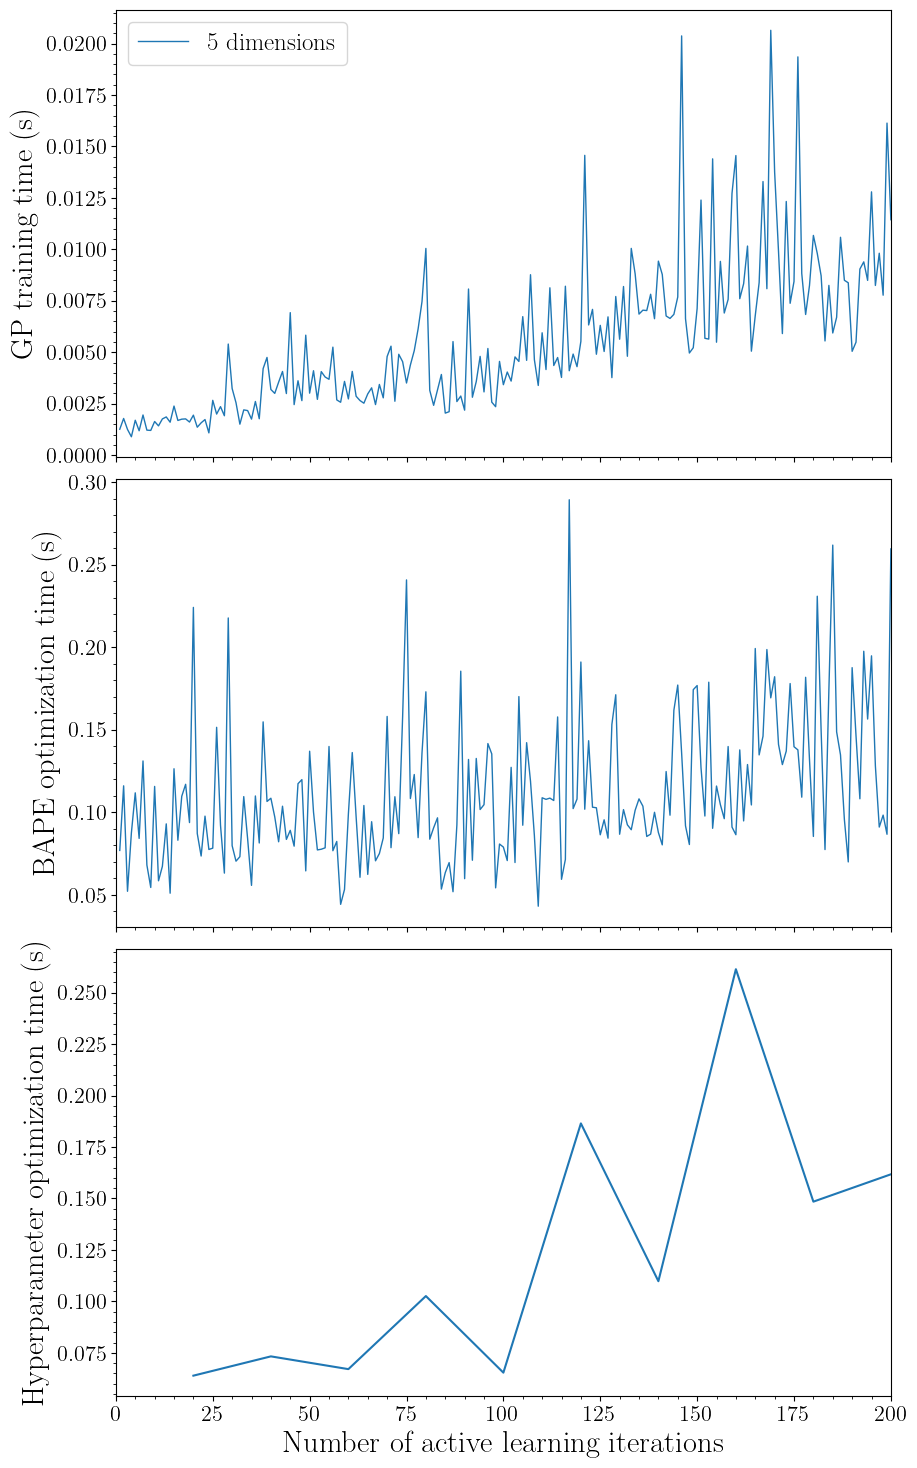

In [14]:
logy = False

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18), sharex=True)
plt.subplots_adjust(hspace=0.05)

# Top panel - Training time
for ii, ndim in enumerate(dimensions):
    ax1.plot(iterations, train_time[ii], label=f"{dimensions[ii]} dimensions", linewidth=1)
ax1.set_ylabel("GP training time (s)", fontsize=22)
ax1.legend(loc="upper left", fontsize=18)
ax1.minorticks_on()

# Middle panel - Optimization time
for ii, ndim in enumerate(dimensions):
    ax2.plot(iterations, opt_time[ii], linewidth=1)
ax2.set_ylabel("BAPE optimization time (s)", fontsize=22)
ax2.minorticks_on()

# # Bottom panel - Total time
for ii, ndim in enumerate(dimensions):
    ax3.plot(hp_opt_iter[ii], hp_opt_time[ii][1:], linewidth=1.5)
ax3.set_xlabel("Number of active learning iterations", fontsize=22)
ax3.set_ylabel("Hyperparameter optimization time (s)", fontsize=22)
ax3.minorticks_on()

if logy:
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    # ax3.set_yscale("log")
ax1.set_xlim(0, iterations[-1])

plt.savefig(f"{savedir}/multivariate_normal_training_time.png", bbox_inches='tight', dpi=800)
plt.show()

Plot the cummulative training time as a bar chart for each dimension.

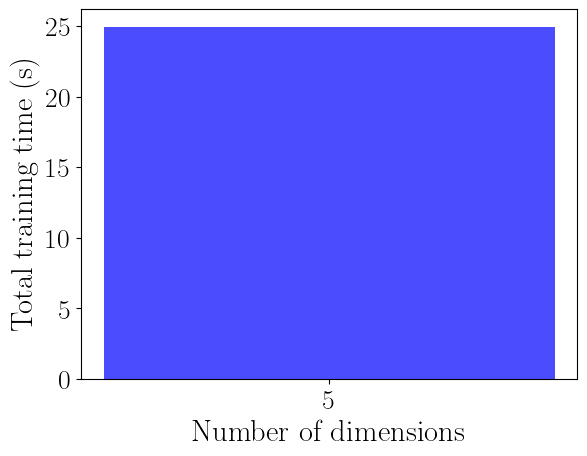

In [15]:
plt.bar(dimensions, cum_time, width=1, color='blue', alpha=0.7)
plt.xlabel("Number of dimensions", fontsize=22)
plt.ylabel("Total training time (s)", fontsize=22)
plt.xticks(dimensions, fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(f"{savedir}/multivariate_normal_total_training_time.png", bbox_inches='tight', dpi=600)
plt.show()